<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [5]:
import pandas as pd
import pickle
import io
import requests
import datetime
import math
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
%matplotlib inline

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


In [6]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.facecolor"] = "white"
sns.set_style("darkgrid", {'legend.frameon': False})
sns.set_context("talk", font_scale=0.95, rc={"lines.linewidth": 2.5})

In [7]:
foodtruck_pickle = '../pickle_jar/foodtruck_df2.pkl'
ft_df = pd.read_pickle(foodtruck_pickle)
ft_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,UNIQUE_STATION,DATE,TIME,DESC,DAY_OF_WEEK,...,HOLIDAY,ENTRIES,EXITS,LAST_ENTRIES,LAST_EXITS,LAST_TIME,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTAL,IN_BK
0,B004,R171,00-00-00,7 AV,BQ,7 AV BQ,09/01/2018,09:00:00,REGULAR,Saturday,...,False,6293248,4614702,6293557,4615002,13:00:00,309,300,609,True
1,B004,R171,00-00-00,7 AV,BQ,7 AV BQ,09/02/2018,09:00:00,REGULAR,Sunday,...,False,6294460,4615867,6294784,4616103,13:00:00,324,236,560,True
2,B004,R171,00-00-00,7 AV,BQ,7 AV BQ,09/03/2018,09:00:00,REGULAR,Monday,...,True,6295556,4616999,6295911,4617273,13:00:00,355,274,629,True
3,B004,R171,00-00-00,7 AV,BQ,7 AV BQ,09/04/2018,09:00:00,REGULAR,Tuesday,...,False,6297760,4618510,6298607,4618758,13:00:00,847,248,1095,True
4,B004,R171,00-00-00,7 AV,BQ,7 AV BQ,09/05/2018,09:00:00,RECOVR AUD,Wednesday,...,False,6300702,4620614,6301626,4620892,13:00:00,924,278,1202,True


In [8]:
# use mask from data_analysis_pipeline.ipynb notebook
total_mask = ((ft_df['DAILY_TOTAL'] < 6000) & (ft_df['DAILY_TOTAL'] != 0))

In [9]:
t20 = (
    ft_df[total_mask]
    .groupby("UNIQUE_STATION")
    ["DAILY_TOTAL"].sum()
    .sort_values(ascending = False)[:20]
    .index.tolist()
)
print(len(t20))
t20

20


['BOROUGH HALL 2345R',
 'JAY ST-METROTEC ACF',
 'BEDFORD AV L',
 'CROWN HTS-UTICA 34',
 'ATL AV-BARCLAY 2345BDNQR',
 'ATL AV-BARCLAY BDNQR2345',
 'KINGS HWY BQ',
 'MYRTLE-WYCKOFF LM',
 'DEKALB AV BDNQR',
 'NOSTRAND AV AC',
 'CHURCH AV BQ',
 'FLATBUSH AV-B.C 25',
 'FRANKLIN AV 2345S',
 'HIGH ST AC',
 'UTICA AV AC',
 'CARROLL ST FG',
 'PROSPECT PARK BQS',
 'NEVINS ST 2345',
 '8 AV N',
 '59 ST NRW']

In [10]:
# ft_df.loc[(ft_df['STATION'].str.contains('CARROLL'))][["STATION", "LINENAME"]].head()
ft_df.loc[(ft_df['STATION'].str.contains('KINGS HWY'))]["STATION"].value_counts()

KINGS HWY    2361
Name: STATION, dtype: int64

In [23]:
search.by_zipcode('11206')

SimpleZipcode(zipcode='11206', zipcode_type='Standard', major_city='Brooklyn', post_office_city='Brooklyn, NY', common_city_list=['Brooklyn'], county='Kings County', state='NY', lat=40.7, lng=-73.94, timezone='Eastern', radius_in_miles=1.0, area_code_list=['347', '718', '917'], population=81677, population_density=56939.0, land_area_in_sqmi=1.43, water_area_in_sqmi=0.0, housing_units=29941, occupied_housing_units=28025, median_home_value=533400, median_household_income=28559, bounds_west=-73.957457, bounds_east=-73.927588, bounds_north=40.713373, bounds_south=40.691599)

In [11]:
def get_population(row):
    result = search.by_coordinates(row["GTFS Latitude"], row["GTFS Longitude"], radius=1, returns=10)
    population = sum([r.population for r in result])
    return population

def get_housing_units(row):
    result = search.by_coordinates(row["GTFS Latitude"], row["GTFS Longitude"], radius=1, returns=10)
    housing_units = sum([r.housing_units for r in result])
    return housing_units

def get_median_household_value(row):
    result = search.by_coordinates(row["GTFS Latitude"], row["GTFS Longitude"], radius=1, returns=10)
    home_value = sum([r.median_home_value if r.median_home_value is not None else 0 for r in result])
    return home_value

def get_median_household_income(row):
    result = search.by_coordinates(row["GTFS Latitude"], row["GTFS Longitude"], radius=1, returns=10)
    home_income = sum([r.median_household_income if r.median_household_income is not None else 0 for r in result])
    return home_income

def get_occupied_housing_values(row):
    result = search.by_coordinates(row["GTFS Latitude"], row["GTFS Longitude"], radius=1, returns=10)
    occ_homes = sum([r.occupied_housing_units for r in result])
    return occ_homes

In [12]:
BK = "Brooklyn"
d = {}

In [15]:
d["BOROUGH_HALL"] = [ft_df.loc[(ft_df['STATION'].str.contains('BOROUGH HALL'))].index, 40.6929, -73.9903, BK]
d["JAY_ST-METROTEC"] = [ft_df.loc[(ft_df['STATION'].str.contains('JAY ST-METROTEC'))].index, 40.6923, -73.9873, BK]
d["BEDFORD"] = [ft_df.loc[(ft_df['STATION'].str.contains('BEDFORD AV'))].index, 40.7178, -73.9575, BK]
d["CROWN"] = [ft_df.loc[(ft_df['STATION'].str.contains('CROWN'))].index, 40.6689, -73.9318, BK]
d["BARCLAY"] = [ft_df.loc[(ft_df['STATION'].str.contains('BARCLAY'))].index, 40.6837, -73.9788, BK]
d["KINGS"] = [ft_df.loc[(ft_df['STATION'].str.contains('KINGS HWY'))].index, 40.6087, -73.9578, BK]
d["MYRTLE-WYCKOFF"] = [ft_df.loc[(ft_df['STATION'].str.contains('MYRTLE-WYCKOFF'))].index, 40.6997, -73.9118, BK]
d["DEKALB"] = [ft_df.loc[(ft_df['STATION'].str.contains('DEKALB'))].index, 40.6898, -73.9812, BK]
d["NOSTRAND"] = [ft_df.loc[(ft_df['STATION'].str.contains('NOSTRAND AV'))].index, 40.6784, -73.9482, BK]
d["CHURCH"] = [ft_df.loc[(ft_df['STATION'].str.contains('CHURCH'))].index, 40.6495, -73.9633, BK]
d["FLATBUSH"] = [ft_df.loc[(ft_df['STATION'].str.contains('FLAT'))].index, 40.6330, -73.9477, BK]
d["FRANKLIN"] = [ft_df.loc[(ft_df['STATION'].str.contains('FRANKLIN'))].index, 40.6811, -73.9557, BK]
d["HIGH_ST-BOOKLYN_BRIDGE"] = [ft_df.loc[(ft_df['STATION'].str.contains('HIGH'))].index, 40.6994, -73.9913, BK]
d["UTICA_AV"] = [ft_df.loc[(ft_df['STATION'].str.contains('UTICA AV'))].index, 40.6794, -73.9306, BK]
d["CARROLL_ST"] = [ft_df.loc[(ft_df['STATION'].str.contains('CARROLL'))].index, 40.6793, -73.9955, BK]
d["PROSPECT_PARK"] = [ft_df.loc[(ft_df['STATION'].str.contains('PROSPECT PARK'))].index, 40.6609, -73.9621, BK]
d["NEVINS"] = [ft_df.loc[(ft_df['STATION'].str.contains('NEVINS'))].index, 40.6883, -73.9805, BK]
d["8_AV"] = [ft_df.loc[(ft_df['STATION'].str.contains('8 AV'))].index, 40.6346, -74.0108, BK]
d["59_ST"] = [ft_df.loc[(ft_df['STATION'].str.contains('59 ST'))].index, 40.6416, -74.0177, BK]

In [16]:
for k, slice_station in d.items():
    # print(k)
    # display(ft_df.loc[slice_station[0], ["STATION", "LINENAME"]].head(2))
    ft_df.loc[slice_station[0], "FULL_NAME"] = k.upper()
    ft_df.loc[slice_station[0], "GTFS Latitude"] = slice_station[1]
    ft_df.loc[slice_station[0], "GTFS Longitude"] = slice_station[2]
    ft_df.loc[slice_station[0], "BOROUGH"] = slice_station[3]

In [17]:
agg_dict = {
    "DAILY_TOTAL": "sum",
}

In [18]:
dff = ft_df.groupby(
    ["FULL_NAME", "GTFS Latitude", "GTFS Longitude", "BOROUGH"], as_index=False
).agg(agg_dict)
dff

,FULL_NAME,GTFS Latitude,GTFS Longitude,BOROUGH,DAILY_TOTAL
0,59_ST,40.6416,-74.0177,Brooklyn,393831
1,8_AV,40.6346,-74.0108,Brooklyn,1139266
2,BARCLAY,40.6837,-73.9788,Brooklyn,1547635
3,BEDFORD,40.7178,-73.9575,Brooklyn,975079
4,BOROUGH_HALL,40.6929,-73.9903,Brooklyn,1480575
5,CARROLL_ST,40.6793,-73.9955,Brooklyn,424951
6,CHURCH,40.6495,-73.9633,Brooklyn,1182638
7,CROWN,40.6689,-73.9318,Brooklyn,891776
8,DEKALB,40.6898,-73.9812,Brooklyn,1031061
9,FLATBUSH,40.6330,-73.9477,Brooklyn,519893


In [19]:
dff["total_population"] = dff.apply(get_population, axis=1)
dff["housing_units"] = dff.apply(get_housing_units, axis=1)
dff["median_household_value"] = dff.apply(get_median_household_value, axis=1)
dff["median_household_income"] = dff.apply(get_median_household_income, axis=1)
dff["occupied_housing_units"] = dff.apply(get_occupied_housing_values, axis=1)
dff["pct_occupied_housing_units"] = ( dff["occupied_housing_units"] / dff["housing_units"] ) * 100
dff["normalized_occupied_housing_units"] = ( dff["occupied_housing_units"] / dff["occupied_housing_units"].max() ) * 10

In [ ]:
dff['median_household_income']

In [14]:
show_cols = [
    "FULL_NAME",
    "DAILY_TOTAL",
    "total_population",
    "housing_units",
    "median_household_value",
    "median_household_income",
    "occupied_housing_units",
    "pct_occupied_housing_units",
]
dff[show_cols]

,FULL_NAME,DAILY_TOTAL,total_population,housing_units,median_household_value,median_household_income,occupied_housing_units,pct_occupied_housing_units
0,59_ST,393831,127863,40025,1198200,81175,37421,93.494066
1,8_AV,1139266,220084,68718,1924900,115491,63598,92.549259
2,BARCLAY,1547635,99369,47654,1770200,177516,44346,93.058295
3,BEDFORD,975079,127051,55936,1382000,110587,50522,90.321081
4,BOROUGH_HALL,1480575,51128,26390,669000,95369,23325,88.385752
5,CARROLL_ST,424951,33336,16149,912000,78174,15216,94.222552
6,CHURCH,1182638,158401,61333,1096200,83656,58602,95.547258
7,CROWN,891776,215320,85895,1525900,97634,79036,92.014669
8,DEKALB,1031061,127375,60380,2162900,221919,54284,89.903942
9,FLATBUSH,519893,62008,22476,485500,55429,20653,91.889126


In [19]:
t_income = dff.sort_values(
    by=["median_household_income"], ascending=False
).head(3).reset_index(drop=True)
t_population = dff.sort_values(
    by=["total_population"], ascending=False
).head(3).reset_index(drop=True)

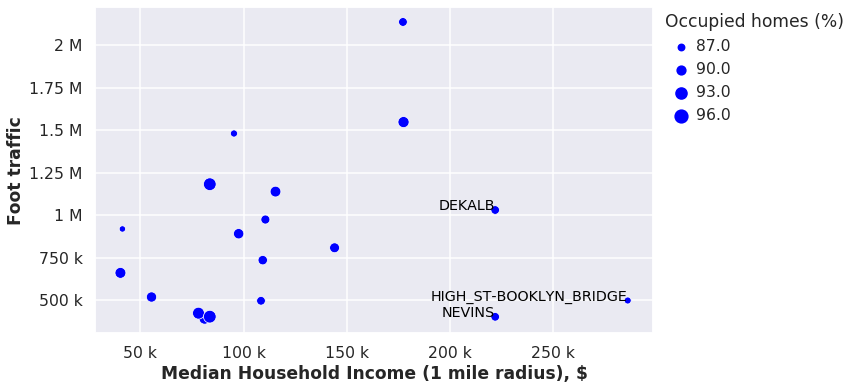

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
p = sns.scatterplot(
    x="median_household_income",
    y="DAILY_TOTAL",
    size="pct_occupied_housing_units",
    data=dff,
    ax=ax,
    legend="brief",
    color="blue"
)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel("Foot traffic", fontweight='bold');
ax.set_xlabel("Median Household Income (1 mile radius), $", fontweight='bold');
handles, labels = ax.get_legend_handles_labels();
l = ax.legend(handles=handles[1:], labels=labels[1:], title="Occupied homes (%)",
          bbox_to_anchor=(1.01, 1),
          loc=2,
          borderpad=None,
          borderaxespad=0.,
          facecolor=None,
          handletextpad=0,
          framealpha=0,
);
l._legend_box.align = "left"
for m in l.legendHandles:
    m.set_color('blue')
for line in range(
    0,
    t_income.shape[0],
):
     p.text(
         t_income["median_household_income"][line],
         t_income["DAILY_TOTAL"][line],
         t_income["FULL_NAME"][line],
         horizontalalignment='right', size='small', color='black', weight='normal'
    )
# plt.savefig('traffic_income_housing.png', dpi=300)

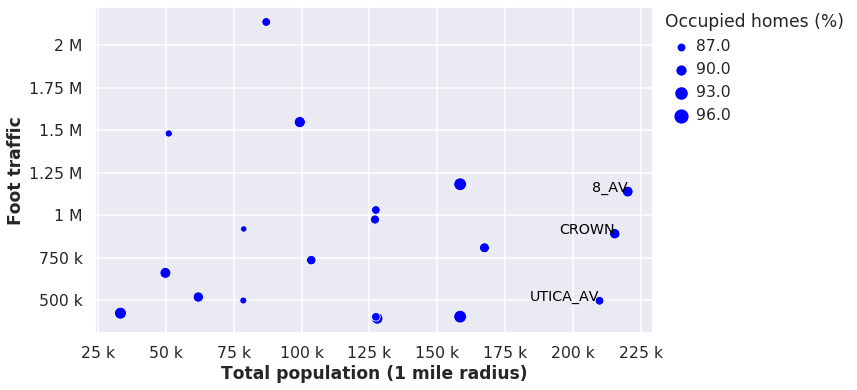

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
p = sns.scatterplot(
    x="total_population",
    y="DAILY_TOTAL",
    size="pct_occupied_housing_units",
    data=dff,
    ax=ax,
    legend="brief",
    color="blue"
)
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel("Foot traffic", fontweight='bold');
ax.set_xlabel("Total population (1 mile radius)", fontweight='bold');
handles, labels = ax.get_legend_handles_labels();
l = ax.legend(handles=handles[1:], labels=labels[1:], title="Occupied homes (%)",
          bbox_to_anchor=(1.01, 1),
          loc=2,
          borderpad=None,
          borderaxespad=0.,
          facecolor=None,
          handletextpad=0,
          framealpha=0,
);
l._legend_box.align = "left"
for m in l.legendHandles:
    m.set_color('blue')
for line in range(
    0,
    t_population.shape[0],
):
     p.text(
         t_population["total_population"][line],
         t_population["DAILY_TOTAL"][line],
         t_population["FULL_NAME"][line],
         horizontalalignment='right', size='small', color='black', weight='normal'
    )
# plt.savefig('traffic_population_housing.png', dpi=300)